In [1]:
import pandas as pd
import numpy as np
import re
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline  

import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    import nltk
    from nltk.tokenize import RegexpTokenizer
    from nltk.stem.wordnet import WordNetLemmatizer
    from nltk.corpus import stopwords, words
    from nltk import FreqDist

    import gensim
    from gensim import corpora, models, similarities
    import pyLDAvis
    import pyLDAvis.gensim

/home/sam/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/home/sam/anaconda3/envs/insight/lib/python3.7/site-packages/funcy/colls.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Set, Iterable, Iterator, defaultdict
/home/sam/anaconda3/envs/insight/lib/python3.7/site-packages/funcy/colls.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Set, Iterable, Iterator, defaultdict
/home/sam/anaconda3/envs/insight/lib/python3.7/site-packages/funcy/flow.py:2: DeprecationWarning: Using or importing the ABCs fro

In [2]:
cities = pd.read_csv('cities_geo2_df.csv', index_col=0)

# Reset index
cities = cities.reset_index()
cities.drop(['index'], axis=1, inplace=True)

In [3]:
#cities.head()

In [4]:
# Run once
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('words')

In [5]:
tokenizer = RegexpTokenizer(r'\w+') # retains alphanumeric character
lmtzr = WordNetLemmatizer()
cached_stop_words = stopwords.words("english")

In [6]:
def lemmatize_dropstop_words(text): 
    print(text)
    clear_output(wait=True)
    return [lmtzr.lemmatize(word) for word in text if 
            (len(word)>2) and 
            (lmtzr.lemmatize(word) not in cached_stop_words) and 
            (word in words.words())
            ]

def remove_num(text): 
    return re.sub("\d+", " ", text)

In [7]:
cities = cities.replace(np.nan, '', regex=True)

In [8]:
# Add my stop words from txt file
my_stop_words = np.genfromtxt('my_stop_words.txt',dtype='str', delimiter=', ').tolist()
cached_stop_words.extend(my_stop_words)

In [9]:
# Read
REFILTER_WORDS = False

In [10]:
if REFILTER_WORDS == True:
    cities['See_tokens'] = cities['See'].str.lower().apply(tokenizer.tokenize).apply(lemmatize_dropstop_words)

In [11]:
if REFILTER_WORDS == True:
    cities['Do_tokens'] = cities['Do'].str.lower().apply(tokenizer.tokenize).apply(lemmatize_dropstop_words)
        
    # Pool tokens
    def pool_tokens(row):
        return row['See_tokens']+row['Do_tokens']

    cities['Pooled_tokens'] = cities.apply(pool_tokens, axis=1)

In [12]:
if REFILTER_WORDS == False:
    cities = pd.read_csv('cities_text_processed_df.csv', index_col = 0)

In [13]:
# If reloaded from .csv file, convert string to list
if type(cities['Pooled_tokens'][0])==str:
    cities['Pooled_tokens'] = cities['Pooled_tokens'].apply(ast.literal_eval)

In [14]:
# Most common words
words = []
for sublist in cities['Pooled_tokens']:
    for item in sublist:
        words.append(item)
        
fdist = FreqDist(words)
fdist.most_common(20)

[('museum', 9558),
 ('park', 7930),
 ('art', 3857),
 ('free', 3827),
 ('old', 3576),
 ('temple', 3433),
 ('well', 3299),
 ('center', 3062),
 ('world', 2996),
 ('town', 2972),
 ('festival', 2790),
 ('road', 2779),
 ('bus', 2682),
 ('river', 2681),
 ('small', 2613),
 ('church', 2584),
 ('walk', 2574),
 ('station', 2569),
 ('local', 2454),
 ('great', 2406)]

In [15]:
# Save cities with final index
cities.to_csv('cities_text_processed_df.csv')

In [16]:
# Join tokens to one string to be compatible w/ sklearn models
def tokens_to_str(tokens):
    return ' '.join(tokens)

cities['Pooled_string'] = cities['Pooled_tokens'].apply(tokens_to_str)

In [31]:
cities.head()

,Country,City,Understand,Get in,Get around,See,Do,Buy,Eat,Sleep,...,Lon,Alt,City_alternative2,Latitude,Longitude,AccentCity,See_tokens,Do_tokens,Pooled_tokens,Pooled_string
0,Afghanistan,Herat,Herat is the second largest city in Afghanista...,The Herat International Airport is situated 15...,NaN,"Ghala Ekhteyaradin, Takht Safar, Bagh Milat, ...",Take a shower in the huge subterranean Hammams.,There are several antique shops on the north ...,Herat has a mixture of traditional and modern ...,"Budget[edit] Mowafaq Hotel, northeast corner ...",...,62.189999,927.0,NaN,NaN,NaN,NaN,"['masjid', 'jami', 'bridge', 'shad', 'tomb', '...","['shower', 'huge', 'subterranean']","[masjid, jami, bridge, shad, tomb, gazer, sang...",masjid jami bridge shad tomb gazer sang haft d...
1,Afghanistan,Kabul,Kabul is a very historic city of the region th...,By plane[edit] Kabul International Airport (IA...,Maps of Kabul are available from Afghanistan I...,Bagh-e Babur (Gardens of Babur). The gardens ...,Kabul Wall. A pleasant hike with rewarding vi...,The Share-e Naw area has some shops. The Kab...,The once thriving restaurant scene in Kabul ha...,"Kabul is not a cheap place to stay, principall...",...,69.183334,1808.0,NaN,NaN,NaN,NaN,"['surround', 'tomb', 'emperor', 'wished', 'bur...","['wall', 'pleasant', 'hike', 'rewarding', 'wal...","[surround, tomb, emperor, wished, buried, orig...",surround tomb emperor wished buried originally...
2,Afghanistan,Jalalabad,NaN,Jalalabad is on the major highway that links K...,NaN,The large reservoir near Sarobi. This is loca...,Go fishing along the river side. Go swimming .,Handi Craft Handicraft is one of most famous ...,Pakora go for special “Pakora” Food in Hindu ...,The government hotel Spingar is on the easter...,...,70.449997,573.0,NaN,NaN,NaN,NaN,"['large', 'reservoir', 'way', 'museum', 'relat...","['fishing', 'river', 'swimming']","[large, reservoir, way, museum, related, perio...",large reservoir way museum related period muse...
3,Afghanistan,Kandahar,Kandahār or Qandahār (Pashto: کندهار ) (Persia...,By plane[edit] Kandahar International Airport ...,NaN,"Kandahar Museum, (Western end of the Eidgah ...",NaN,"Afghanistan International Bank (AIB), Kabul Ba...","There are plenty of food choices in Kandahar, ...","Budget[edit] Armani Hotel, (Two miles from c...",...,65.699997,1015.0,NaN,NaN,NaN,NaN,"['museum', 'western', 'important', 'mausoleum'...",[],"[museum, western, important, mausoleum, baba, ...",museum western important mausoleum baba wali b...
4,Afghanistan,Kunduz,NaN,Most visitors will arrive by road from Pol-e K...,"The city is fairly small. The local roads, li...",There's not much for tourists here.,NaN,NaN,The usual Afghan fare - kebab or lamb with ric...,NaN,...,68.860001,394.0,NaN,NaN,NaN,NaN,[],[],[],


# Vectorize text

In [ ]:
# Final level of stop words


In [18]:
# Initialize Model
vec=TfidfVectorizer(min_df=3)

In [19]:
# CountVec fit to Bag of Words
vec1 = vec.fit_transform(cities['Pooled_string'])

In [20]:
# Cosine similarity matrix
cosims_mat = 1-pairwise_distances(vec1.A, metric="cosine")
cosims_mat

cosims_df = pd.DataFrame(cosims_mat)
cosims_df.head()

# Save
cosims_df.to_csv('data/cos_sims.csv')

# Save stacked version
cosims_stacked = cosims_df.stack()
cosims_stacked.to_csv('data/cos_sims_stacked.csv')

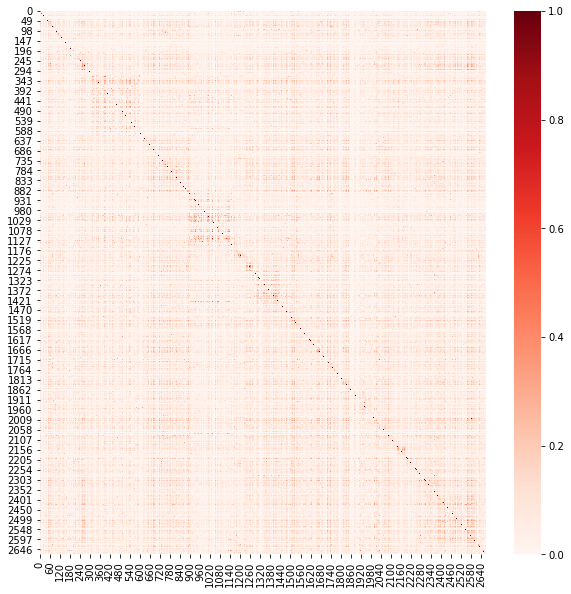

In [21]:
# Visualize cosims matrix

plt.figure(figsize=(10,10))
sns.heatmap(cosims_df.values,cmap='Reds')

In [22]:
# Test output cities given user input

input_city = 'New York City'
input_index = [cities[cities['City']==input_city].index]
output_index = cosims_df.iloc[input_index[0][0]].sort_values(ascending = False).head(10)
cities.iloc[output_index.index]

,Country,City,Understand,Get in,Get around,See,Do,Buy,Eat,Sleep,...,Lon,Alt,City_alternative2,Latitude,Longitude,AccentCity,See_tokens,Do_tokens,Pooled_tokens,Pooled_string
2527,United States,New York City,New York City is one of the global hubs of int...,By plane[edit] IATA: NYC is the code for all N...,"Main article: New York City/Get around‎ ""...","Like most of the great world cities, New York ...",A general word of advice on sightseeing in New...,New York is arguably the fashion capital of th...,"New York has, as you might expect of the Big A...",The costs of hotel accommodation in New York C...,...,-74.005974,2.0,NaN,NaN,NaN,NaN,"['great', 'world', 'new', 'york', 'abundance',...","['general', 'word', 'advice', 'new', 'york', '...","[great, world, new, york, abundance, great, wo...",great world new york abundance great would imp...
2386,United Kingdom,York,"York was known as Eboracum by the Romans, who ...",By car[edit] Although York is not directly on ...,By foot[edit] The roads within the old city (i...,"York Minster, ☎ +44 1904 557216, [1]. M-Sa 09...","Walk around the city walls, [16]. Daily 8AM-s...",York comes highly recommended for its unique s...,"Budget[edit] For budget eating, try any tradit...",Hotel rates in York tend to be more expensive ...,...,-1.083333,14.0,NaN,NaN,NaN,NaN,"['york', 'minster', 'cathedral', 'northern', '...","['walk', 'daily', 'sunset', 'best', 'vantage',...","[york, minster, cathedral, northern, york, min...",york minster cathedral northern york minster h...
2592,United States,Syracuse,NaN,By bus/train[edit] William F. Walsh Regional T...,By car[edit] A car is probably the best way to...,Up-to-date information about the happenings in...,"Rosamond Gifford Zoo (Burnet Park), One Conse...","Music[edit] Sound Garden, 310 W. Jefferson St....","Budget[edit] The Brooklyn Pickle, 1600 West Ge...","Downtown[edit] Comfort Inn & Suites Airport, 6...",...,-112.063889,NaN,Syracuse,41.089444,-112.063889,Syracuse,"['date', 'easily', 'new', 'available', 'free',...","['zoo', 'burnet', 'park', 'conservation', 'ave...","[date, easily, new, available, free, coffee, m...",date easily new available free coffee museum a...
2617,United States,Yonkers,NaN,"By plane[edit] Westchester County Airport, 24...",Westchester County operates a very extensive n...,"The Hudson River Museum, 511 Warburton Ave, +1...","Sprain Ridge Park, Jackson Ave, Yonkers, +1 91...",Cross County Center also known as Cross County...,Nathan's Famous Hot Dogs2290 Central Park Ave....,"Hampton Inn & Suites, 160 Corporate Blvd, ☎ +1...",...,-95.260556,NaN,Yonkers,36.052778,-95.260556,Yonkers,"['river', 'museum', 'ave', 'regional', 'histor...","['sprain', 'ridge', 'park', 'ave', 'mountain',...","[river, museum, ave, regional, history, valley...",river museum ave regional history valley art p...
284,Canada,Toronto,"In 1998, the cities of Toronto, Scarborough, N...",By plane[edit] Airline Terminal Guide Ter...,"Toronto is huge, and most roads run for very l...",Individual listings can be found in Toronto's ...,Individual listings can be found in Toronto's ...,"Toronto has ample opportunities for shopping, ...",Toronto is generally considered to be one of N...,Individual listings can be found in Toronto's ...,...,-79.416306,173.0,NaN,NaN,NaN,NaN,"['individual', 'district', 'art', 'gallery', '...","['individual', 'district', 'walk', 'eclectic',...","[individual, district, art, gallery, free, adm...",individual district art gallery free admission...
2562,United States,Rochester,"Rochester, known as The Flower City and The Wo...",By plane[edit] Greater Rochester International...,Most people will tell you that a car is a virt...,Rochester isn't the most popular place for sig...,You might sometimes catch residents complainin...,Shopping around Rochester is dominated by the ...,Dining in Rochester is typical of most mid-siz...,There are only seven hotels within the Rochest...,...,-77.615555,155.0,NaN,NaN,NaN,NaN,"['popular', 'river', 'gorge', 'certainly',

In [25]:
input_index = cities.index[cities['City']=='New York City'][0] # Get index of input
input_sims = pd.DataFrame(cosims_df.iloc[input_index]) # Get sims for input city
sims_sorted = input_sims.sort_values(by=input_index, ascending=False) # Sort sims
sims_top = sims_sorted.iloc[1:101]
top_index = sims_top.index
top_cities = cities.iloc[top_index][['City','Country','Lat','Lon','Pooled_tokens']]
top_cities

In [28]:
cities.shape

(2671, 25)